<a href="https://colab.research.google.com/github/alvov26/ambiguous-medieval-game/blob/main/QEGP_addition_to_progress.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quantum Engineering Group Project - Progress document Anna Nijssen


# Proton transfer
This document studies proton transfer occuring during the hydrolis of peptide bonds. For more information, see the overleaf document. The necessary sources to support my claims and code are listed there as well.

In [ ]:
!pip install pyscf
!pip install qiskit-nature
!pip install biopython

!pip install qiskit qiskit-nature qiskit-algorithms qiskit-aer pyscf
!pip install pylatexenc

import numpy as np
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP
from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit.circuit.library import TwoLocal

from Bio.PDB import PDBParser
from Bio.PDB import MMCIFParser
from pyscf import gto, scf, ao2mo
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Location of the hydrogen atom connected to Ser-OH: [ 2.23400005 20.01600075 21.14800072]
Extracted 25 atoms from catalytic triad

Qiskit-ready coordinates:
("N", (-1.091000, 23.702000, 15.122000)),
("C", (-1.135000, 22.261000, 14.812000)),
("C", (-2.218000, 21.524000, 15.556000)),
("O", (-2.506000, 20.379999, 15.251000)),
("C", (0.230000, 21.492001, 15.071000)),
("C", (0.589000, 20.986000, 16.466999)),
("N", (1.396000, 21.586000, 17.353001)),
("C", (0.087000, 19.841000, 17.073000)),
("C", (1.368000, 20.927999, 18.492001)),
("N", (0.608000, 19.893999, 18.281000)),
("N", (4.117000, 28.132000, 15.323000)),
("C", (3.074000, 27.236000, 15.798000)),
("C", (2.160000, 27.992001, 16.764000)),
("O", (2.187000, 27.882999, 18.000000)),
("C", (3.654000, 25.959000, 16.471001)),
("C", (2.691000, 24.742001, 16.547001)),
("O", (1.615000, 24.745001, 15.930000)),
("O", (3.026000, 23.750000, 17.197001)),
("N", (0.128000, 20.184000, 23.820000)),
("C", (0.222000, 21.306000, 22.920000)),
("C", (-0.836000, 22

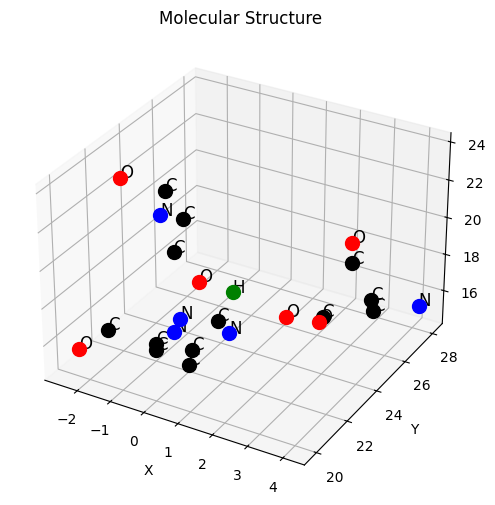

In [ ]:

input_file = "/content/1PPB.cif"

# Load CIF structure
parser = MMCIFParser(QUIET=True)
structure = parser.get_structure("thrombin", input_file)

# Extract Ser–His–Asp triad
triad_residues = [195, 57, 102]  # SER, HIS, ASP
chain_id = "H" # I knew chain_id was H by manually printing first 300 residues of each chain

atoms = []
for model in structure:
    for chain in model:
        if chain.id != chain_id:
            continue
        for residue in chain:
            if residue.get_id()[1] in triad_residues:
                for atom in residue:
                    # Ensure element exists
                    if hasattr(atom, "element"):
                        atoms.append((residue.get_resname(), residue.get_id()[1], atom.get_name(), atom.element, atom.coord))


# Finding the oxygen atom next to which we need to place the hydrogen atom:
ser_O_idx = None
for i, (residue_name, residue_id, atom_name, elem, coord) in enumerate(atoms):
    if residue_name == "SER" and residue_id == 195 and atom_name == "OG":
        ser_O_idx = i
        break

# Placing the hydrogen atom:
O_coord = atoms[ser_O_idx][4]
H_coord = O_coord + np.array([0.96, 0.0, 0.0])  # O-H bond is approximately 0.9572 Å (source in overleaf document)
atoms.append(["SER", 195, "HG", "H", H_coord])
print("Location of the hydrogen atom connected to Ser-OH:", H_coord)


print(f"Extracted {len(atoms)} atoms from catalytic triad")
print("\nQiskit-ready coordinates:")
for atom in atoms:
    x, y, z = atom[4]
    elem = atom[3]
    print(f'("{elem}", ({x:.6f}, {y:.6f}, {z:.6f})),')

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

# Atom colors
colors = {'H':'green','C':'black','N':'blue','O':'red','S':'yellow'}

for a,b,c,atom, coord in atoms:
    ax.scatter(coord[0], coord[1], coord[2], color=colors.get(atom,'grey'), s=100)
    ax.text(coord[0], coord[1], coord[2], atom, fontsize=12)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title("Molecular Structure")
plt.show()




In [ ]:
# Checking if proton placed at spot in list where I expect it to be (remove this code later):
proton_index = None
for i, atom in enumerate(atoms):
    if atom[0] == "SER" and atom[1] == 195 and atom[2] == "HG":
        proton_index = i
        break

print(atoms[proton_index])
print(atoms[-1])




# Selecting the His57 N towards which the proton must move:
his_N_idx = None
for n, atom in enumerate(atoms):
  if atom[0] == "HIS" and atom[1] == 57 and atom[2] == "NE2":
    his_N_idx = n

print(f"The His57 N atom index number is {his_N_idx}.")


# Distance the proton must travel in total:
# (Here I still assume the proton to end up at H, perhaps we can determine a more accurate position)
tot_dist = np.linalg.norm(atoms[his_N_idx][4] - atoms[-1][4])

print(f"The proton must travel a total of {np.round(tot_dist,3)} Angstrom.")

['SER', 195, 'HG', 'H', array([ 2.23400005, 20.01600075, 21.14800072])]
['SER', 195, 'HG', 'H', array([ 2.23400005, 20.01600075, 21.14800072])]
The His57 N atom index number is 9.
The proton must travel a total of 3.298 Angstrom.


In [ ]:
def moving_proton(atoms, O_index, N_index, ds):
  atoms_new = atoms.copy()

  O_coord = atoms[O_index][4]           # Our fourth index consists of the coordinates
  N_coord = atoms[N_index][4]
  proton_position_old = atoms[-1][4]    # The last element consists of the hydrogen atom

  direction_movement = N_coord - proton_position_old
  proton_position_new = proton_position_old + ds * direction_movement/np.linalg.norm(direction_movement)

  atom = atoms[-1]
  atoms_new[-1] = (atom[0], atom[1], atom[2], atom[3], proton_position_new)
  # for i, atom in enumerate(atoms):
  #   if i == proton_index:
  #     atoms_new.append((atom[0], atom[1], atom[2], atom[3], proton_position_new))
  #   else:
  #     atoms_new.append(atom)

  distance_OH = np.linalg.norm(O_coord - proton_position_new)
  distance_NH = np.linalg.norm(N_coord - proton_position_new)
  diff = distance_OH - distance_NH

  return atoms_new, diff


In [ ]:
proton_displacements = np.linspace(0.0, tot_dist, 5)
energies = []
diff = []

for n, ds in enumerate(proton_displacements):
  atoms, diff_n = moving_proton(atoms, ser_O_idx, his_N_idx, ds)
  diff.append(diff_n)

  atoms_part = []
  for atom in atoms:
     atoms_part.append((atom[3], atom[4]))

  # Configure driver and problem
  # Convert list of tuples to string format (for pySCF)
  atom_string = "; ".join([f"{a[0]} {a[1][0]} {a[1][1]} {a[1][2]}" for a in atoms_part])
  driver = PySCFDriver(atom=atom_string, basis="sto3g", charge=0, spin=0)  # Spin is zero now because number of electrons even
  problem = driver.run()

  # TRANSFORMER: Reducing a 24-atom system to fit on a simulator
  # This picks 2 electrons and 2 orbitals (e.g., HOMO = Highest Occupied Molecular Orbital and LUMO = Lowest Unoccupied Molecular Orbital)
  transformer = ActiveSpaceTransformer(num_electrons=(2,2), num_spatial_orbitals=3)
  reduced_problem = transformer.transform(problem)


  # JW mapping and VQE
  hamiltonian = reduced_problem.hamiltonian.second_q_op() #second quantization form
  mapper = JordanWignerMapper() #converts electron operators -> qubit operators
  qubit_op = mapper.map(hamiltonian)

  ansatz = TwoLocal(qubit_op.num_qubits, ['ry', 'rz'], 'cz', reps=1, entanglement='full') # Output = guess for quantum state of the molecule
  ansatz.decompose().draw('mpl')
  vqe = VQE(Estimator(), ansatz, SLSQP(maxiter=100))

  result = vqe.compute_minimum_eigenvalue(qubit_op)

  # Results
  # The 'interpret' method estimates neglected terms (from when we reduced the problem)
  interpreted_result = reduced_problem.interpret(result)

  energies.append(interpreted_result.total_energies[0])




/tmp/ipython-input-696222685.py:30: DeprecationWarning: The class ``qiskit.circuit.library.n_local.two_local.TwoLocal`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.n_local instead.
  ansatz = TwoLocal(qubit_op.num_qubits, ['ry', 'rz'], 'cz', reps=1, entanglement='full') # Output = guess for quantum state of the molecule
/tmp/ipython-input-696222685.py:30: DeprecationWarning: The class ``qiskit.circuit.library.n_local.two_local.TwoLocal`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.n_local instead.
  ansatz = TwoLocal(qubit_op.num_qubits, ['ry', 'rz'], 'cz', reps=1, entanglement='full') # Output = guess for quantum state of the molecule
/tmp/ipython-input-696222685.py:30: DeprecationWarning: The class ``qiskit.circuit.library.n_local.two_local.TwoLocal`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.n_loca

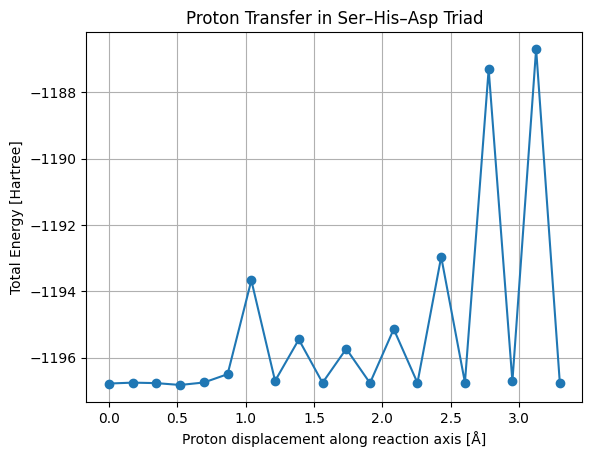

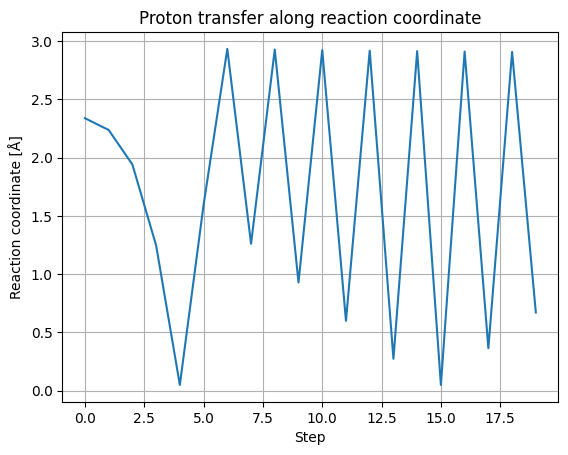

In [ ]:
plt.plot(proton_displacements, energies, marker='o')
plt.xlabel("Proton displacement along reaction axis [Å]")
plt.ylabel("Total Energy [Hartree]")
plt.title("Proton Transfer in Ser–His–Asp Triad")
plt.grid(True)
plt.show()


plt.plot(np.abs(diff))
plt.xlabel("Step")
plt.ylabel("Reaction coordinate [Å]")
plt.title("Proton transfer along reaction coordinate")
plt.grid(True)
plt.show()